<a href="https://colab.research.google.com/github/skarskar/deploy/blob/main/notebook/V3_Capstone_Loan_Default_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install category_encoders
!pip install feature_engine
!pip install scikit-learn==1.3.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.9/328.9 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 48.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [2]:
!pip install smote-variants

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.2/416.2 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.0 MB/s eta 0:00:00
  Created wheel for minisom: filename=MiniSom-2.3.1-py3-none-any.whl size=10588 sha256=f3f2de43d4262466b4fdfe272f997fb78d2ea5219440f1cfb86a817e89577e86
  Stored in directory: /root/.cache/pip/wheels/c7/92/d2/33bbda5f86fd8830510b16aa98c8dd420129b5cb24248fd6db
  Created wheel for statistics: filename=statistics-1.0.3.5-py3-none-any.whl size=7436 sha256=cc619d0868535120a88d6f70b8c3694c37bb3507247b20f5403f2c914cf7f2fe
  Stored in directory: /root/.cache/pip/wheels/59/bd/aa/41ad56fbb723d36e457b5be74feb992cdac2855a6999ba34a1
Successfully built minisom statistics


In [3]:
# mlp for binary classification
import pandas as pd
import numpy as np
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
import category_encoders as ce
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_extraction import DictVectorizer
from scipy.stats.mstats import winsorize
#from category_encoders import TargetEncoder
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import TargetEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, log_loss, classification_report, accuracy_score,  roc_auc_score, roc_curve, auc
from pickle import dump
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [4]:
%time
# Set your environment in a notebook:
# Set the Environment
# Ignore Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

#Write out the versions of all packages to requirements.txt
!pip freeze >> requirements.txt

# Remove the restriction on Jupyter that limits the columns displayed (the ... in the middle)
# pd.set_option('max_columns',None)
pd.options.display.max_columns = None
pd.options.display.max_rows = None
# Docs: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.set_option.html#

# Pretty Display of variables.  for instance, you can call df.head() and df.tail() in the same cell and BOTH display w/o print
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# List of ALL Magic Commands.  To run a magic command %var  --- i.e.:  %env
%lsmagic
# %env  -- list environment variables
# %%time  -- gives you information about how long a cel took to run
# %%timeit -- runs a cell 100,000 times and then gives you the average time the cell will take to run (can be LONG)
# %pdb -- python debugger

# to display nice model diagram
from sklearn import set_config
set_config(display='diagram')

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.30"

import tensorflow
print("\n tensorflow: " + tensorflow.__version__)

print("\n Numpy: " + np.__version__)
print("\n sklearn: " + sklearn.__version__)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs

 tensorflow: 2.12.0

 Numpy: 1.23.5

 sklearn: 1.3.1


# Methods

In [5]:
# prepare input data
def prepare_inputs(feature, target):
  #https://towardsdatascience.com/dealing-with-categorical-variables-by-using-target-encoder-a0f1733a4c69
  #oe = ce.CountEncoder(return_df=True, normalize=True)
  #oe.fit(feature)
  encoder = TargetEncoder(smooth='auto', target_type='binary')
  encoder.fit(feature, target)
  feature_enc = encoder.transform(feature)
  #X_train_enc = oe.transform(X_train.drop(columns='loan_default_status'))
  #X_test_enc = X_test #pd.get_dummies(X_test)  #oe.transform(X_test)
  # save the scaler
  dump(encoder, open('encoder.pkl', 'wb'))
  return feature_enc#, X_test_enc

 # prepare target
def prepare_targets(y_train, y_test):
  le = LabelEncoder()
  le.fit(y_train)
  y_train_enc = le.transform(y_train)
  y_test_enc = le.transform(y_test)
  return y_train_enc, y_test_enc

 # feature selection based on chi2
def select_features(X_train, y_train, X_test):
  fs = SelectKBest(score_func=chi2, k=1)
  fs.fit(X_train, y_train)
  X_train_fs = fs.transform(X_train)
  X_test_fs = fs.transform(X_test)
  return X_train_fs, X_test_fs, fs

 # feature selection based on Mutual Importance
def select_features_mutual_info(X_train, y_train, X_test):
  fs = SelectKBest(score_func=mutual_info_classif, k=1)
  fs.fit(X_train, y_train)
  X_train_fs = fs.transform(X_train)
  X_test_fs = fs.transform(X_test)
  return X_train_fs, X_test_fs, fs

# Load Data

In [6]:
'''
ID: unique ID of representative
Loan Amount: loan amount applied
Funded Amount:The total amount committed to that loan at that point in time.
Funded Amount Investor: The total amount committed by investors for that loan at that point in time.
Term: term of loan (in months)
Batch Enrolled: batch numbers to representatives
Interest Rate: interest rate (%) on loan
Grade: grade by the bank
Sub Grade: sub-grade by the bank
Debit to Income: ratio of representative's total monthly debt repayment divided by self reported monthly income excluding mortgage
Delinquency - two years: The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
Inquires - six months: total number of inquiries in last 6 months
Open Account: number of open credit line in representative's - credit line
Public Record: number of derogatory public records
Revolving Balance: total credit revolving balance
Revolving Utilities: amount of credit a representative is using - relative to revolving_balance
Total Accounts: total number of credit lines available in - representatives credit line
Initial List Status: unique listing status of the loan - - W(Waiting), F(Forwarded)
Total Received Interest: total interest received till date
Total Received Late Fee: total late fee received till date
Recoveries: post charge off gross recovery
Collection Recovery Fee: post charge off collection fee
Collection 12 months Medical: total collections in last 12 months - excluding medical collections
Application Type: indicates when the representative is an individual or joint
Last week Pay: indicates how long (in weeks) a representative has paid EMI after batch enrolled
Accounts Delinquent: number of accounts on which the representative is delinquent
Total Collection Amount: total collection amount ever owed
Total Current Balance: total current balance from all accounts
Total Revolving Credit Limit: total revolving credit limit
Loan Status: 1 = Defaulter, 0 = Non Defaulters
verification_status: Indicates if income was verified by LC, not verified, or if the income source was verified
Home Ownership: The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER.
'''

path = 'https://raw.githubusercontent.com/skarskar/MLWorkshop/main/dataset/Loan%20Default%20prediction%20dataset%20Train.csv'
df_test=pd.read_csv("https://raw.githubusercontent.com/skarskar/MLWorkshop/main/dataset/Loan%20Default%20prediction%20dataset%20Test.csv")
df= read_csv(path)
df.shape


"\nID: unique ID of representative\nLoan Amount: loan amount applied\nFunded Amount:The total amount committed to that loan at that point in time.\nFunded Amount Investor: The total amount committed by investors for that loan at that point in time.\nTerm: term of loan (in months)\nBatch Enrolled: batch numbers to representatives\nInterest Rate: interest rate (%) on loan\nGrade: grade by the bank\nSub Grade: sub-grade by the bank\nDebit to Income: ratio of representative's total monthly debt repayment divided by self reported monthly income excluding mortgage\nDelinquency - two years: The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years\nInquires - six months: total number of inquiries in last 6 months\nOpen Account: number of open credit line in representative's - credit line\nPublic Record: number of derogatory public records\nRevolving Balance: total credit revolving balance\nRevolving Utilities: amount of credit a representativ

(67463, 35)

In [ ]:
df.info()

In [ ]:
df.nunique()

In [ ]:
df.isna().sum()

# Preprocessing
## split data into train, validation & test at the earliest so that bias is not introduced.

In [7]:
df.rename(columns={'Loan Status': 'Loan Default Status', 'Employment Duration': 'Home Ownership','Home Ownership':'Annual Income'}, inplace=True)

#drop columns as these only have 1 unique value
df.drop(columns=['Payment Plan','Accounts Delinquent'], inplace=True)
df.drop(columns=['ID'], inplace=True)
df.shape

(67463, 32)

In [8]:
# change columns & categorical column values to lower case and replace space with hyphen
df.columns = df.columns.str.lower().str.replace(' ', '_')
string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')
df.head(1).T

,0
loan_amount,10000
funded_amount,32236
funded_amount_investor,12329.36286
term,59
batch_enrolled,bat2522922
interest_rate,11.135007
grade,b
sub_grade,c4
home_ownership,mortgage
annual_income,176346.6267


In [ ]:
loan_title_dict_cat = {'credit_card_refinancing':['credit_card_refinance_loan','credit_card_refi','cc_refi','cc-refinance','cc_refinance','credit_card_refinance'],
                       'debt_consolidation':['debt_consolidation_2013','conso','consolidated','dept_consolidation','card_consolidation','credit_consolidation',
                                             'cc_consolidation','consolidation_loan','credit_card_consolidation','debt_consolidation_loan','consolidate',
                                             'consolidation','bill_consolidation','loan_consolidation'],
                       'personal_loan':['getting_ahead','wedding_loan','loan1','loan_1','vacation','myloan','personal','lending_club','major_purchase','my_loan'],
                       'home_loan':['home','home_buying','house','car_financing','car_loan'],
                       'home_improvement_loan':['pool','bathroom','home_improvement'],
                       'payoff_loan':['credit_pay_off','credit_card_pay_off','bill_payoff','pay_off','pay_off_bills','bills','get_debt_free','credit_payoff',
                                      'debt_free','freedom','credit_card_payoff','payoff','debt_payoff','debt_reduction','credit_card_paydown',
                                      'get_out_of_debt','relief'],
                       'medical_loan':['medical_expenses','medical'],
                       'other':['green_loan','moving_and_relocation'],
                       'business_loan':['lending_loan'],
                       'credit_loan':['credit','cc','cc_loan','credit_card_loan','credit_cards','credit_card_debt','cards',
                                      'loan','debt_loan','debt','credit_card'],
                       'refinance_loan':['refinance','refi']}

In [ ]:
#reducing the number of categories in loan_title
df['loan_title']=df['loan_title'].replace(to_replace='payoff', value='payoff_loan')
df['loan_title']=df['loan_title'].replace(to_replace='business', value='business_loan')

for key, value in loan_title_dict_cat.items():
  for item in value:
    df['loan_title']=df['loan_title'].replace(to_replace=item, value=key)
df['loan_title'].value_counts().sort_values()

In [ ]:
#df[df.groupby(['loan_title'])['loan_title'].transform('count')]
#df.groupby(['loan_title'])['loan_title'].agg('count').ge(100)
#df.groupby(by=col).loan_default_status.agg(['mean'])
#plt.figure(figsize=(26,40))
#df[df.groupby(['loan_title'])['loan_title'].transform('count').ge(100)].loan_title.unique()
#fig, ax = plt.subplots(figsize=(26,10))
#sns.catplot(data=df[df.groupby(['loan_title'])['loan_title'].transform('count').ge(100)],x='loan_title',hue="loan_title", kind="count", height=5, aspect=2)
#graph=sns.countplot(data=df[df.groupby(['loan_title'])['loan_title'].transform('count').ge(100)],ax=ax,x='loan_title')
#graph.set_xticklabels(graph.get_xticklabels(),rotation=90)
#plt.show()
#df[df.groupby(['loan_title'])['loan_title'].transform('count').ge(100)]
print(len(df[df.groupby(['loan_title'])['loan_title'].transform('count').ge(50)]))
print(len(df))

#excluding loan_title categories with count < 1000
df=df[df.groupby(['loan_title'])['loan_title'].transform('count').ge(50)]
df.head(5)

In [9]:
#check for duplicates
df.drop_duplicates(inplace=True)

In [ ]:
df.select_dtypes(exclude='object').drop(columns='loan_default_status').describe().T

In [ ]:
## Outliers handling using Winsorizer IQR capping method
# iterate over the numeric columns in the DataFrame and plot a boxplot for each column
for col in df.drop(columns='loan_default_status').select_dtypes(exclude=['object']).columns:
    #fig, (ax1) = plt.subplots(1,2,1, figsize=(3,3))
      plt.figure(figsize=(12,6))
      plt.subplot(1,2,1)
      sns.boxplot(data=df[col])
      plt.title(col)

      plt.subplot(1,2,2)
      sns.distplot(df[col], kde=True)
      plt.title(col)
      plt.show()

In [ ]:
for col in df.drop(columns='loan_default_status').select_dtypes(exclude=['object']).columns:
  plt.figure(figsize=(3,3))
  sns.boxplot(x='loan_default_status', y=col, data=df)

<Axes: >

<Axes: xlabel='loan_default_status', ylabel='loan_amount'>

<Axes: >

<Axes: xlabel='loan_default_status', ylabel='funded_amount'>

<Axes: >

<Axes: xlabel='loan_default_status', ylabel='funded_amount_investor'>

<Axes: >

<Axes: xlabel='loan_default_status', ylabel='term'>

<Axes: >

<Axes: xlabel='loan_default_status', ylabel='interest_rate'>

<Axes: >

<Axes: xlabel='loan_default_status', ylabel='annual_income'>

<Axes: >

<Axes: xlabel='loan_default_status', ylabel='debit_to_income'>

<Axes: >

<Axes: xlabel='loan_default_status', ylabel='delinquency_-_two_years'>

<Axes: >

<Axes: xlabel='loan_default_status', ylabel='inquires_-_six_months'>

<Axes: >

<Axes: xlabel='loan_default_status', ylabel='open_account'>

<Axes: >

<Axes: xlabel='loan_default_status', ylabel='public_record'>

<Axes: >

<Axes: xlabel='loan_default_status', ylabel='revolving_balance'>

<Axes: >

<Axes: xlabel='loan_default_status', ylabel='revolving_utilities'>

<Axes: >

<Axes: xlabel='loan_default_status', ylabel='total_accounts'>

<Axes: >

<Axes: xlabel='loan_default_status', ylabel='total_received_interest'>

<Axes: >

<Axes: xlabel='loan_default_status', ylabel='total_received_late_fee'>

<Axes: >

<Axes: xlabel='loan_default_status', ylabel='recoveries'>

<Axes: >

<Axes: xlabel='loan_default_status', ylabel='collection_recovery_fee'>

<Axes: >

<Axes: xlabel='loan_default_status', ylabel='collection_12_months_medical'>

<Axes: >

<Axes: xlabel='loan_default_status', ylabel='last_week_pay'>

<Axes: >

<Axes: xlabel='loan_default_status', ylabel='total_collection_amount'>

<Axes: >

<Axes: xlabel='loan_default_status', ylabel='total_current_balance'>

<Axes: >

<Axes: xlabel='loan_default_status', ylabel='total_revolving_credit_limit'>

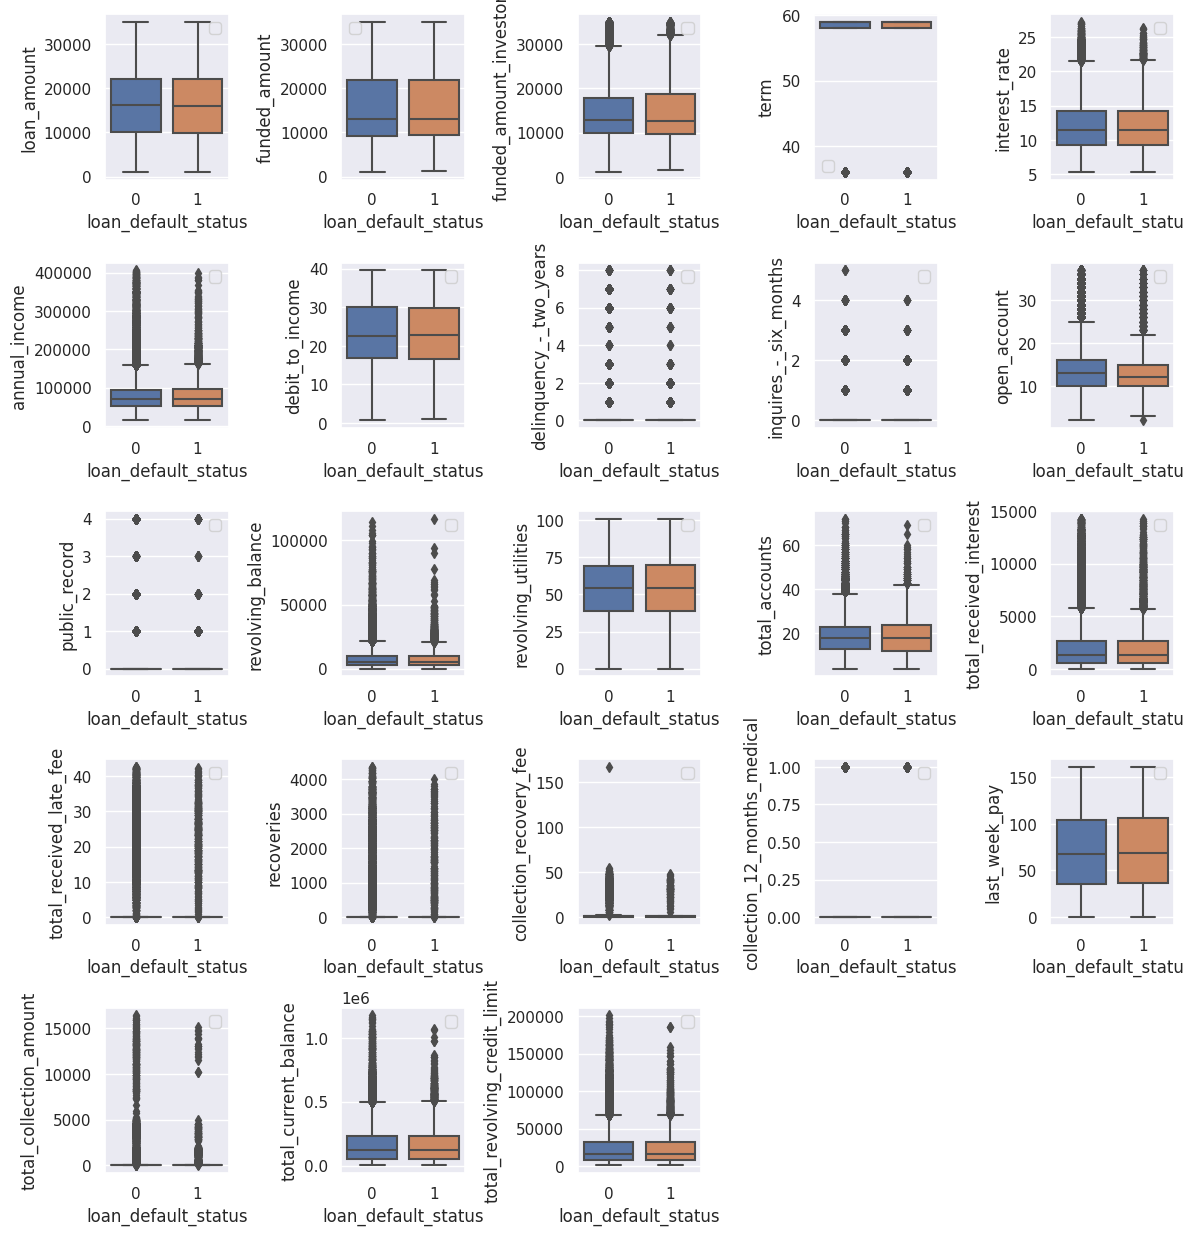

In [22]:
fig = plt.figure(figsize = (12, 15))
j = 1
for col in df.drop(columns='loan_default_status').select_dtypes(exclude=['object']).columns:
  plt.subplot(6, 5, j)
  j += 1
  sns.set(rc={"figure.figsize":(4, 4)})
  sns.boxplot(x='loan_default_status', y=col, data=df)
  plt.legend(loc='best')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

In [ ]:
import seaborn as sns
sns.boxplot(x = 'loan_title', y = 'term', data=df)

In [ ]:
capper = Winsorizer(capping_method='iqr',
                    tail='both',
                    fold=3,
                    variables=['funded_amount_investor', 'interest_rate',
                               'annual_income', 'open_account', 'total_accounts',
                               'revolving_balance','total_received_interest','total_current_balance',
                               'total_revolving_credit_limit'])
capper.fit(df)
print(capper.right_tail_caps_)
print(capper.left_tail_caps_)
# transform the data
df = capper.transform(df)

Winsorizer(capping_method='iqr', tail='both',
           variables=['funded_amount_investor', 'interest_rate',
                      'annual_income', 'open_account', 'total_accounts',
                      'revolving_balance', 'total_received_interest',
                      'total_current_balance', 'total_revolving_credit_limit'])

{'funded_amount_investor': 41735.32152800001, 'interest_rate': 28.882690784500003, 'annual_income': 223423.76113499998, 'open_account': 34.0, 'total_accounts': 53.0, 'revolving_balance': 33067.0, 'total_received_interest': 8915.115904949998, 'total_current_balance': 762363.0, 'total_revolving_credit_limit': 104119.5}
{'funded_amount_investor': -14096.042424000007, 'interest_rate': -5.392010561000003, 'annual_income': -77110.595015, 'open_account': -8.0, 'total_accounts': -17.0, 'revolving_balance': -20325.5, 'total_received_interest': -5687.2552535999985, 'total_current_balance': -483609.0, 'total_revolving_credit_limit': -63817.5}


In [ ]:
# correlation between y and features
##sns.set(rc={'figure.figsize':(30,10)})
#sns.set_context("talk", font_scale=0.7)
fig, ax = plt.subplots(figsize=(30, 10))
#corr_enc = pd.DataFrame(prepare_inputs(df, df.loan_default_status), columns=df.columns.tolist())
sns.heatmap(df.iloc[:].corr(method='spearman'), cmap='rainbow_r', annot=True)

In [ ]:
df.drop("loan_default_status", axis=1).apply(lambda x: x.corr(df.loan_default_status,method='spearman')).sort_values(ascending=False).plot(kind='barh', figsize=(14,8))

In [ ]:
#distribution of the target. There is data imbalance
# Resample is required
df.loan_default_status.value_counts()

0    60324
1     6121
Name: loan_default_status, dtype: int64

In [ ]:
# Rebalancing is required as bias toward Non-Defaulters
(6241/(6241+61222))*100

9.250996842713784

<Axes: title={'center': 'Target  Class'}, xlabel='loan_default_status', ylabel='Frequency'>

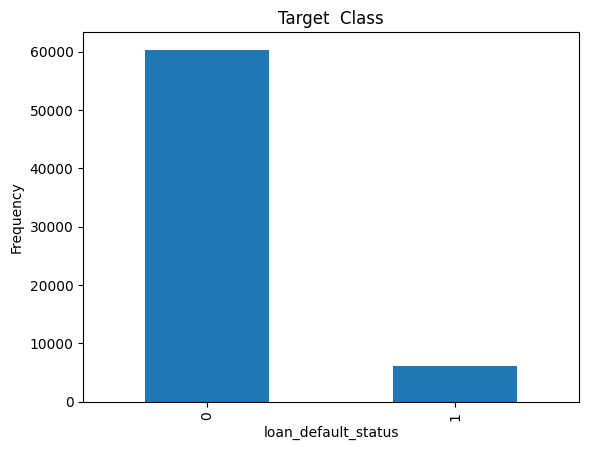

In [ ]:
df["loan_default_status"].value_counts(normalize=False).plot(
    kind="bar", xlabel="loan_default_status", ylabel="Frequency", title="Target  Class"
)

In [ ]:
global_loan_default_status_mean = df.loan_default_status.mean()
global_loan_default_status_mean

0.09212130333358416

In [ ]:
# total_current_balance, total_revolving_credit_limit revolving_balance are highly skewed.  Log transformation is applied
#var=["total_current_balance", "total_revolving_credit_limit", "revolving_balance"]

df["log_total_current_balance"]=np.log(1+df.total_current_balance)
df["log_total_revolving_credit_limit"]=np.log(1+df.total_revolving_credit_limit)
df["log_revolving_balance"]=np.log(1+df.revolving_balance)
df.drop(columns=['total_current_balance','total_revolving_credit_limit','revolving_balance'],inplace=True)
df.shape

(67463, 32)

In [ ]:
#"collection_recovery_fee"  "total_received_late_fee"  "recoveries", "total_collection_amount"
# these features indicate high possibilities of defaults and data is nosiy; transform to dummuy variables using 90p as cutoffs becasue overall bad rate is around 10%
df.shape
df["collection_recovery_fee_ind"]=0
df.loc[df["collection_recovery_fee"]>1.3,"collection_recovery_fee_ind"]=1
#df_new[df_new["collection_recovery_fee"]>1.3]=1
df["total_received_late_fee_ind"]=0
df.loc[df["total_received_late_fee"]>7.5,"total_received_late_fee_ind"]=1
#df_new[df_new["total_received_late_fee"]>7.5]=1
df["recoveries_ind"]=0
df.loc[df["recoveries"]>7.5,"recoveries_ind"]=1
#df_new[df_new["recoveries"]>7.5]=1
#df_new[df_new["recoveries"]>7.5]
#df_new[df_new["recoveries_ind"]==1].head(5)
df.drop(columns=["collection_recovery_fee","recoveries",
           "total_received_late_fee"], inplace=True)
df.shape

(67463, 32)

(67463, 32)

In [ ]:
#Feature Selection based on Chi2
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif

features = df_new.drop(columns='loan_default_status',axis=1)
print(features.shape)
target = df_new.loan_default_status
print(target.shape)
cate = [i for i in features.select_dtypes(include='object').columns]
num = [i for i in features.select_dtypes(exclude='object').columns]
#X_train_enc = prepare_inputs(features, target)
X_train_enc = pd.DataFrame(prepare_inputs(features, target), columns=features.columns.tolist())
#y_train_enc, y_test_enc = prepare_targets(df.loan_default_status, df.loan_default_status)
X_train, X_test, y_train, y_test = train_test_split(X_train_enc
, target, test_size=0.20, random_state=42, shuffle=True, stratify=target)

# create model instance
bst = XGBClassifier(n_estimators=100, objective='binary:logistic')

score_list = []
for k in range(1, len(features.columns)+1):
  k_best = SelectKBest(score_func=f_classif, k=k)
  k_best.fit(X_train, y_train)
#np.set_printoptions(precision=3)
  k_features = k_best.transform(X_train)
  k_features_test = k_best.transform(X_test)
  bst.fit(k_features, y_train)
  kbest_preds = bst.predict(k_features_test)
  score_kbest = round(accuracy_score(y_test, kbest_preds), 3)
  score_list.append(score_kbest)
# filter down X based on kept columns
#features = features[[val for i,val in enumerate(features.columns) if k_best.get_support()[i]]]
#features.head(1)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(13, 10))
x = np.arange(1, len(features.columns)+1)
y = score_list

ax.bar(x, y, width=0.2)
ax.set_xlabel('Number of features selected using mutual information')
ax.set_ylabel('Accuracy Score')
ax.set_ylim(0, 1.0)
ax.set_xticks(np.arange(1, 29))
ax.set_xticklabels(np.arange(1, 29), fontsize=12)

for i, v in enumerate(y):
    plt.text(x=i+1, y=v+0.05, s=str(v), ha='center')

plt.tight_layout()

In [ ]:
import statsmodels.api as sm
ols = sm.OLS(target, X_train_enc).fit()
print(ols.summary())

                                 OLS Regression Results                                 
Dep. Variable:     loan_default_status   R-squared (uncentered):                   1.000
Model:                             OLS   Adj. R-squared (uncentered):              1.000
Method:                  Least Squares   F-statistic:                          4.132e+07
Date:                 Fri, 20 Oct 2023   Prob (F-statistic):                        0.00
Time:                         22:55:11   Log-Likelihood:                      3.1689e+05
No. Observations:                67463   AIC:                                 -6.337e+05
Df Residuals:                    67432   BIC:                                 -6.334e+05
Df Model:                           31                                                  
Covariance Type:             nonrobust                                                  
                                       coef    std err          t      P>|t|      [0.025      0.975]
---------

## Feature Importance/Selection based on Risk Ratio

In [ ]:
#Mutual Information - https://triveratechvirtual6x.my.webex.com/recordingservice/sites/triveratechvirtual6x.my/recording/ccb27c09288d103cbbfdf2d7f7787d99/playback
# Does Category mean vary widely from global mean?

for col in df.select_dtypes(include='object').columns:
    df_group = df.groupby(by=col).loan_default_status.agg(['mean'])
    df_group['diff'] = df_group['mean'] - global_loan_default_status_mean

    #Risk Ratio. Higher risk to default if ratio is significantly >1
    df_group['risk'] = df_group['mean'] / global_loan_default_status_mean
    df_group['count'] = df[col].value_counts()
    display(df_group)

In [ ]:
#Following features can be dropped based on Risk Ratio
# initial_list_status, application_type, verification_status
df.drop(columns=['initial_list_status','application_type','verification_status'], axis=1, inplace=True)
df.shape

(67463, 29)

In [ ]:
# Select object type data and numerical data columns seperately
cate = [i for i in df.select_dtypes(include='object').columns]
num = [i for i in df.select_dtypes(exclude='object').columns]
print(cate)
print(num)

['batch_enrolled', 'grade', 'sub_grade', 'home_ownership', 'loan_title']
['loan_amount', 'funded_amount', 'funded_amount_investor', 'term', 'interest_rate', 'annual_income', 'debit_to_income', 'delinquency_-_two_years', 'inquires_-_six_months', 'open_account', 'public_record', 'revolving_utilities', 'total_accounts', 'total_received_interest', 'collection_12_months_medical', 'last_week_pay', 'total_collection_amount', 'loan_default_status', 'log_total_current_balance', 'log_total_revolving_credit_limit', 'log_revolving_balance', 'collection_recovery_fee_ind', 'total_received_late_fee_ind', 'recoveries_ind']


In [ ]:
#Categorical unique values
df[cate].nunique()

## Feature Engineering transformation

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67463 entries, 0 to 67462
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   loan_amount                   67463 non-null  int64  
 1   funded_amount                 67463 non-null  int64  
 2   funded_amount_investor        67463 non-null  float64
 3   term                          67463 non-null  int64  
 4   batch_enrolled                67463 non-null  object 
 5   interest_rate                 67463 non-null  float64
 6   grade                         67463 non-null  object 
 7   sub_grade                     67463 non-null  object 
 8   home_ownership                67463 non-null  object 
 9   annual_income                 67463 non-null  float64
 10  loan_title                    67463 non-null  object 
 11  debit_to_income               67463 non-null  float64
 12  delinquency_-_two_years       67463 non-null  int64  
 13  i

In [ ]:
df.hist(bins=25, figsize=(15, 25), layout=(-1, 5), edgecolor="black")
plt.tight_layout();

In [ ]:
df.hist(bins=25, figsize=(15, 25), layout=(-1, 5), edgecolor="black")
plt.tight_layout();

In [ ]:
df.select_dtypes(exclude='object').drop(columns='loan_default_status').describe(percentiles=[0.01,0.05,0.10,0.25,0.50,0.75,0.9,0.99]).T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,99%,max
loan_amount,67463.0,16848.902776,8367.865726,1014.000000,2358.240000,4485.100000,6053.000000,10012.000000,16073.000000,22106.000000,29772.000000,34163.140000,35000.000000
funded_amount,67463.0,15770.599114,8150.992662,1014.000000,4017.620000,5894.300000,6986.000000,9266.500000,13042.000000,21793.000000,29309.800000,34077.000000,34999.000000
funded_amount_investor,67463.0,14621.799323,6785.345170,1114.590204,4224.114235,6327.979784,7591.177420,9831.684984,12793.682170,17807.594120,24468.425468,33910.711728,34999.746430
term,67463.0,58.173814,3.327441,36.000000,36.000000,58.000000,58.000000,58.000000,59.000000,59.000000,59.000000,59.000000,59.000000
interest_rate,67463.0,11.846258,3.718629,5.320006,5.493987,6.134823,7.035958,9.297147,11.377696,14.193533,16.911372,21.910677,27.182348
annual_income,67463.0,79712.809346,41341.702207,14573.537170,24036.927676,33448.726146,39480.366016,51689.843335,69335.832680,94623.322785,137477.166860,223423.761135,223423.761135
debit_to_income,67463.0,23.299241,8.451824,0.675299,6.461818,10.205682,12.472440,16.756416,22.656658,30.048400,35.464472,39.137538,39.629862
delinquency_-_two_years,67463.0,0.327127,0.800888,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,8.000000
inquires_-_six_months,67463.0,0.145754,0.473291,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,5.000000
open_account,67463.0,14.254451,6.184520,2.000000,5.000000,7.000000,8.000000,10.000000,13.000000,16.000000,24.000000,34.000000,34.000000


In [ ]:
drop_list=["batch_enrolled"]

df_mr=df.drop(columns=drop_list,axis=1)
df_mr.shape



(67463, 28)

In [ ]:
# Select object type data and numerical data columns seperately

cate = [i for i in df_mr.select_dtypes(include='object').columns]
num = [i for i in df_mr.select_dtypes(exclude='object').columns]
print(cate)
print(num)

['grade', 'sub_grade', 'home_ownership', 'loan_title']
['loan_amount', 'funded_amount', 'funded_amount_investor', 'term', 'interest_rate', 'annual_income', 'debit_to_income', 'delinquency_-_two_years', 'inquires_-_six_months', 'open_account', 'public_record', 'revolving_utilities', 'total_accounts', 'total_received_interest', 'collection_12_months_medical', 'last_week_pay', 'total_collection_amount', 'loan_default_status', 'log_total_current_balance', 'log_total_revolving_credit_limit', 'log_revolving_balance', 'collection_recovery_fee_ind', 'total_received_late_fee_ind', 'recoveries_ind']


In [ ]:
#One-Hot Encoding of Categorical Column
df_mr.shape
cat=['grade', 'sub_grade', 'home_ownership', 'loan_title']
#df_mr= pd.get_dummies(df_mr, columns = cate)

df_mr.shape

(67463, 28)

(67463, 28)

In [ ]:
df_mr.head(5)

,loan_amount,funded_amount,funded_amount_investor,term,interest_rate,grade,sub_grade,home_ownership,annual_income,loan_title,debit_to_income,delinquency_-_two_years,inquires_-_six_months,open_account,public_record,revolving_utilities,total_accounts,total_received_interest,collection_12_months_medical,last_week_pay,total_collection_amount,loan_default_status,log_total_current_balance,log_total_revolving_credit_limit,log_revolving_balance,collection_recovery_fee_ind,total_received_late_fee_ind,recoveries_ind
0,10000,32236,12329.36286,59,11.135007,b,c4,mortgage,176346.62670,debt_consolidation,16.284758,1,0,13,0,74.932551,7,2929.646315,0,49,31,0,12.648519,8.797851,10.096048,0,0,0
1,3609,11940,12191.99692,59,12.237563,c,d3,rent,39833.92100,debt_consolidation,15.412409,0,0,12,0,78.297186,13,772.769385,0,109,53,0,12.115113,9.946834,6.700731,0,0,0
2,28276,9311,21603.22455,59,12.545884,f,d4,mortgage,91506.69105,debt_consolidation,28.137619,0,0,14,0,2.073040,20,863.324396,0,66,34,0,11.405363,10.171834,7.519692,0,1,0
3,11170,6954,17877.15585,59,16.731201,c,c3,mortgage,108286.57590,debt_consolidation,18.043730,1,0,7,0,67.467951,12,288.173196,0,39,40,0,9.125871,11.005677,9.533872,0,0,0
4,16890,13226,13539.92667,59,15.008300,c,d4,mortgage,44234.82545,credit_card_refinancing,17.209886,1,3,13,1,85.250761,22,129.239553,0,18,430,0,11.744275,10.024820,7.342779,0,1,1


In [ ]:
#Encode using Target Encoder
#TargetEncode

features = df_mr.drop(columns='loan_default_status',axis=1)
target = df_mr.loan_default_status
cate = [i for i in features.select_dtypes(include='object').columns]
num = [i for i in features.select_dtypes(exclude='object').columns]
print(cate)
print(num)
#X_train_enc = prepare_inputs(features, target)
X_train_enc = pd.DataFrame(prepare_inputs(features, target), columns=features.columns.tolist())
#y_train_enc, y_test_enc = prepare_targets(df.loan_default_status, df.loan_default_status)

features.head(1)

['grade', 'sub_grade', 'home_ownership', 'loan_title']
['loan_amount', 'funded_amount', 'funded_amount_investor', 'term', 'interest_rate', 'annual_income', 'debit_to_income', 'delinquency_-_two_years', 'inquires_-_six_months', 'open_account', 'public_record', 'revolving_utilities', 'total_accounts', 'total_received_interest', 'collection_12_months_medical', 'last_week_pay', 'total_collection_amount', 'log_total_current_balance', 'log_total_revolving_credit_limit', 'log_revolving_balance', 'collection_recovery_fee_ind', 'total_received_late_fee_ind', 'recoveries_ind']


,loan_amount,funded_amount,funded_amount_investor,term,interest_rate,grade,sub_grade,home_ownership,annual_income,loan_title,debit_to_income,delinquency_-_two_years,inquires_-_six_months,open_account,public_record,revolving_utilities,total_accounts,total_received_interest,collection_12_months_medical,last_week_pay,total_collection_amount,log_total_current_balance,log_total_revolving_credit_limit,log_revolving_balance,collection_recovery_fee_ind,total_received_late_fee_ind,recoveries_ind
0,10000,32236,12329.36286,59,11.135007,b,c4,mortgage,176346.6267,debt_consolidation,16.284758,1,0,13,0,74.932551,7,2929.646315,0,49,31,12.648519,8.797851,10.096048,0,0,0


In [ ]:
# split into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X_train_enc
, target, test_size=0.20, random_state=42, shuffle=True, stratify=target)
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(X_train_scaled.shape)
print(y_train.shape)
print(X_test_scaled.shape)
print(y_test.shape)
X_train_scaled.shape


(53970, 27)
(53970,)
(13493, 27)
(13493,)


(53970, 27)

In [ ]:
#Accuracy Score
model =  LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train_scaled, y_train)
# evaluate the model
yhat = model.predict(X_test_scaled)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.4f' % (accuracy*100))

LogisticRegression(random_state=42, solver='liblinear')

Accuracy: 100.0000


In [ ]:
from xgboost import XGBClassifier
# create model instance
bst = XGBClassifier(n_estimators=100, objective='binary:logistic')
# fit model
bst.fit(X_train_scaled, y_train)
# make predictions
preds = bst.predict(X_test_scaled)
accuracy = accuracy_score(y_test, preds)
print('Accuracy: %.4f' % (accuracy*100))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Accuracy: 100.0000


##Feature Coeffiecients

['loan_amount', 'funded_amount', 'funded_amount_investor', 'term', 'interest_rate', 'grade', 'sub_grade', 'home_ownership', 'annual_income', 'loan_title', 'debit_to_income', 'delinquency_-_two_years', 'inquires_-_six_months', 'open_account', 'public_record', 'revolving_utilities', 'total_accounts', 'total_received_interest', 'collection_12_months_medical', 'last_week_pay', 'total_collection_amount', 'log_total_current_balance', 'log_total_revolving_credit_limit', 'log_revolving_balance', 'collection_recovery_fee_ind', 'total_received_late_fee_ind', 'recoveries_ind']
Feature: 0, Score: 0.35126
Feature: 1, Score: 0.30159
Feature: 2, Score: 1.68122
Feature: 3, Score: 0.01059
Feature: 4, Score: 1.68173
Feature: 5, Score: 0.00143
Feature: 6, Score: 0.00163
Feature: 7, Score: 0.00134
Feature: 8, Score: 1.65769
Feature: 9, Score: 0.01046
Feature: 10, Score: 1.68129
Feature: 11, Score: 0.00737
Feature: 12, Score: -0.00236
Feature: 13, Score: 0.00402
Feature: 14, Score: 0.00164
Feature: 15, Sco

Text(0.5, 1.0, 'Feature Coefficient')

Text(0.5, 0, 'index')

Text(0, 0.5, 'coefficient')

<BarContainer object of 27 artists>

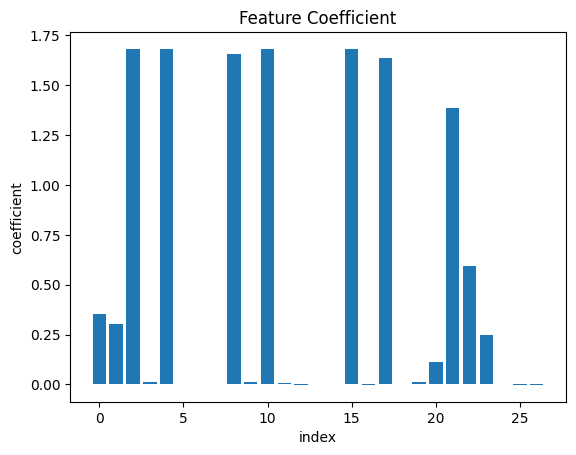

In [ ]:

coeffs = model.coef_.reshape(-1)
# visualizing coefficients
index = pd.DataFrame(X_train_scaled, columns = features.columns.tolist()).columns.tolist()
print(index)
#(pd.DataFrame(coeffs, index = index, columns = ['coeff']).sort_values(by = 'coeff')
 #.plot(kind='barh', figsize=(8,24)))
# summarize feature importance
for i,v in enumerate(coeffs):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.title('Feature Coefficient')
plt.xlabel('index')
plt.ylabel('coefficient')
plt.bar([x for x in range(len(coeffs))], coeffs)
plt.show()

In [ ]:
'''
# filter variables near zero coefficient value
temp = pd.DataFrame(coeffs, index = index, columns = ['coeff']).sort_values(by = 'coeff')
temp = temp[(temp['coeff']>1) | (temp['coeff']< -1)]
# drop those features
cols_coeff = temp.index.to_list()
X_train = pd.DataFrame(X_train, columns = df.drop(columns='loan_default_status', axis=1).columns.tolist())[cols_coeff]
X_test = pd.DataFrame(X_test, columns = df.drop(columns='loan_default_status', axis=1).columns.tolist())[cols_coeff]
X_train.head(5)
X_train.shape
'''

In [ ]:
#Recheck Accuracy Score
model = LogisticRegression(solver='liblinear', random_state=12)
model.fit(X_train_scaled, y_train)
# evaluate the model
yhat = model.predict(X_test_scaled)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

LogisticRegression(random_state=12, solver='liblinear')

Accuracy: 100.00


[[12245     0]
 [    0  1248]]


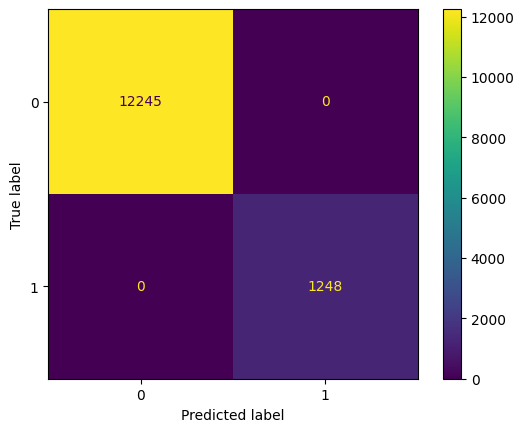

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12245
           1       1.00      1.00      1.00      1248

    accuracy                           1.00     13493
   macro avg       1.00      1.00      1.00     13493
weighted avg       1.00      1.00      1.00     13493



In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test, yhat)
print(cm)
# Plot confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()
print(classification_report(y_test, yhat))

In [ ]:
print('Percentage of Non Defaulters :',(y_train[y_train==0].value_counts()/len(y_train) ) * 100)
print('Percentage of Defaulters :',(y_train[y_train==1].value_counts()/len(y_train) ) * 100)

Percentage of Non Defaulters : 0    90.748564
Name: loan_default_status, dtype: float64
Percentage of Defaulters : 1    9.251436
Name: loan_default_status, dtype: float64


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, yhat)
print(fpr, tpr, thresholds)

[0. 0. 1.] [0. 1. 1.] [inf  1.  0.]


In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score=roc_auc_score(y_test, yhat)
roc_auc_score

1.0

In [ ]:
roc_auc = auc(fpr, tpr)
roc_auc

1.0

<Figure size 500x500 with 0 Axes>

(-0.02, 1.02)

(-0.02, 1.02)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC curve')

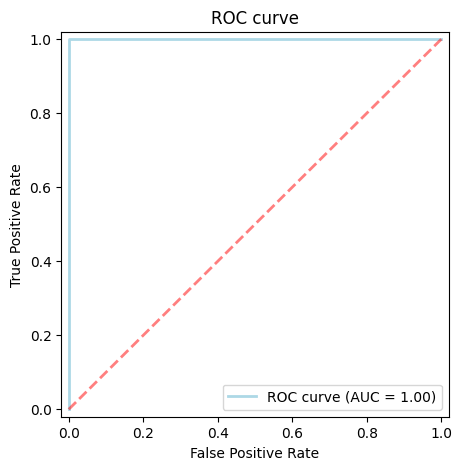

In [ ]:
#plot roc curve

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='lightblue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

##  Neural Network

In [ ]:
# keras - tensorflow
# check version
!pip install keras-tuner --upgrade
import tensorflow
print(tensorflow.__version__)
from tensorflow import keras
# mlp for binary classification
import pandas as pd
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import seaborn as sns
import matplotlib.pyplot as plt
from keras.layers import Dropout
%matplotlib inline
import keras_tuner


In [ ]:
df_mr.info()

In [ ]:
#df_mr_enc = prepare_inputs(df_mr, df_mr)
X_train_scaled_v1, X_test_scaled_v1, y_train_v1, y_test_v1 = X_train_scaled.copy(),X_test_scaled.copy(),y_train.copy(),y_test.copy()
#X_train_scaled.shape
#X=X_train_enc
#y=target
X_train_scaled_v1=X_train_scaled_v1.astype('float32')
X_test_scaled_v1=X_test_scaled_v1.astype('float32')
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True, stratify=target)
print(X_train_scaled_v1.shape, X_test_scaled_v1.shape, y_train_v1.shape, y_test_v1.shape)

(53970, 27) (13493, 27) (53970,) (13493,)


In [ ]:
X_train_scaled_v1.shape
n_features = X_train_scaled_v1.shape[1]
print("num of features:" + str(n_features))


(53970, 27)

num of features:27


In [ ]:
#hyperparameter Tunning
def nn_builder(hp) :
  model = keras.Sequential()
 # Tune the number of layers.
  for i in range(hp.Int("num_layers", 2,5)):
    model.add(keras.layers.Dense(
        hp.Choice('units', [16,32,48,60,72]),
        activation='relu', input_shape=(n_features,)))
    model.add(keras.layers.Dense(hp.Choice('units', [16,32,48,60,72]), activation='relu'))
    opt = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=opt , loss='binary_crossentropy')
  return model
tuner = keras_tuner.RandomSearch(
    hypermodel=nn_builder,
    objective="val_loss",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,

)

In [ ]:
tuner.search(X_train_scaled_v1, y_train_v1, epochs=1, validation_data=(X_test_scaled_v1, y_test_v1))
tuner.search_space_summary()

Trial 3 Complete [00h 00m 30s]
val_loss: 0.5114717483520508

Best val_loss So Far: 0.3120889663696289
Total elapsed time: 00h 01m 27s
Search space summary
Default search space size: 2
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 48, 60, 72], 'ordered': True}


In [ ]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=1)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 28, 28))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                448       
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dense_5 (Dense)             (None, 16)                272       
                                                                 
Total params: 1,808
Trainable params: 1,808
Non-trainabl

In [ ]:
# Step 1: define model

metrics = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]
#add dropout for Regularization


model = Sequential()
model.add(Dense(60, activation='relu', kernel_initializer='truncated_normal', input_shape=(n_features,)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu', kernel_initializer='truncated_normal'))

model.add(Dense(1, activation='sigmoid'))

# compile the model
opt = keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=metrics)

# train the model
NN=model.fit(X_train_scaled_v1, y_train_v1, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
1687/1687 [==============================] - 14s 4ms/step - loss: 0.0035 - cross entropy: 0.0035 - Brier score: 0.0010 - tp: 4990.0000 - fp: 30.0000 - tn: 48947.0000 - fn: 3.0000 - accuracy: 0.9994 - precision: 0.9940 - recall: 0.9994 - auc: 1.0000 - prc: 1.0000
Epoch 2/50
1687/1687 [==============================] - 8s 5ms/step - loss: 1.0653e-06 - cross entropy: 1.0653e-06 - Brier score: 1.1785e-10 - tp: 4993.0000 - fp: 0.0000e+00 - tn: 48977.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000
Epoch 3/50
1687/1687 [==============================] - 6s 4ms/step - loss: 3.3524e-07 - cross entropy: 3.3524e-07 - Brier score: 6.4254e-11 - tp: 4993.0000 - fp: 0.0000e+00 - tn: 48977.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000
Epoch 4/50
1687/1687 [==============================] - 5s 3ms/step - loss: 1.2556e-07 - cross entropy: 1.2556e-07 - Brier score: 1.3187e-11 -

In [ ]:
#save model & scaler
model.save('/content/model')
import joblib
joblib.dump(scaler, '/content/scaler.pkl')

['/content/scaler.pkl']

In [ ]:
!zip -r /content/capstone_model.zip /content/model

  adding: content/model/ (stored 0%)
  adding: content/model/keras_metadata.pb (deflated 87%)
  adding: content/model/saved_model.pb (deflated 87%)
  adding: content/model/assets/ (stored 0%)
  adding: content/model/fingerprint.pb (stored 0%)
  adding: content/model/variables/ (stored 0%)
  adding: content/model/variables/variables.index (deflated 69%)
  adding: content/model/variables/variables.data-00000-of-00001 (deflated 26%)


In [ ]:
from google.colab import files
files.download('/content/capstone_model.zip')
files.download('/content/encoder.pkl')
files.download('/content/scaler.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

422/422 [==============================] - 2s 5ms/step
[[1.000e+00]
 [2.139e-14]
 [3.795e-15]
 ...
 [4.692e-15]
 [3.639e-14]
 [1.000e+00]]
[[12245     0]
 [    0  1248]]


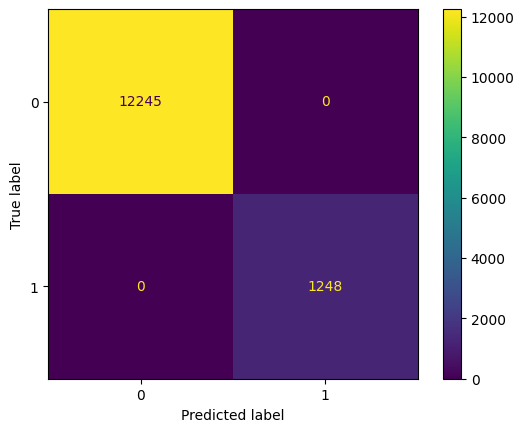

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12245
           1       1.00      1.00      1.00      1248

    accuracy                           1.00     13493
   macro avg       1.00      1.00      1.00     13493
weighted avg       1.00      1.00      1.00     13493



In [ ]:
yhat = model.predict(X_test_scaled_v1)
print(yhat)
# Compute confusion matrix
cm = confusion_matrix(y_test_v1, yhat>0.5)
print(cm)
# Plot confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()
print(classification_report(y_test_v1, yhat>0.5))

In [ ]:
# evaluate the model
Results =model.evaluate(X_test_scaled_v1, y_test_v1, verbose=0)
print(Results)
print("accuary and ROC:")
print(Results[7], Results[10])


[5.6406454892110255e-14, 5.6406454892110255e-14, 1.1586134221334888e-24, 1248.0, 0.0, 12245.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]
accuary and ROC:
1.0 1.0


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_v1, yhat)
print(fpr, tpr, thresholds)

[0.    0.    0.166 0.166 0.175 0.175 0.179 0.179 0.184 0.185 0.199 0.199
 0.208 0.208 0.3   0.301 0.303 0.303 0.326 0.327 0.351 0.351 0.373 0.373
 0.383 0.383 0.401 0.402 0.414 0.414 0.414 0.415 0.416 0.417 0.417 0.417
 0.446 0.446 0.456 0.456 0.457 0.457 0.471 0.471 0.476 0.476 0.478 0.479
 0.489 0.49  0.507 0.507 0.518 0.518 0.52  0.52  0.533 0.533 0.549 0.549
 0.551 0.551 0.552 0.552 0.561 0.561 0.575 0.575 0.588 0.588 0.616 0.617
 0.623 0.623 0.647 0.648 0.653 0.653 0.655 0.655 0.665 0.665 0.669 0.669
 0.675 0.675 0.689 0.689 0.69  0.69  0.699 0.7   0.722 0.722 0.752 0.752
 0.756 0.756 0.762 0.762 0.77  0.77  0.784 0.784 0.788 0.788 0.792 0.792
 0.807 0.807 0.81  0.81  0.812 0.813 0.819 0.819 0.824 0.825 0.857 0.858
 0.88  0.88  0.885 0.885 0.888 0.888 0.89  0.89  0.955 0.955 1.    1.   ] [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

In [ ]:
roc_auc = auc(fpr, tpr)
roc_auc

1.0

<Figure size 500x500 with 0 Axes>

(-0.02, 1.02)

(-0.02, 1.02)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC curve')

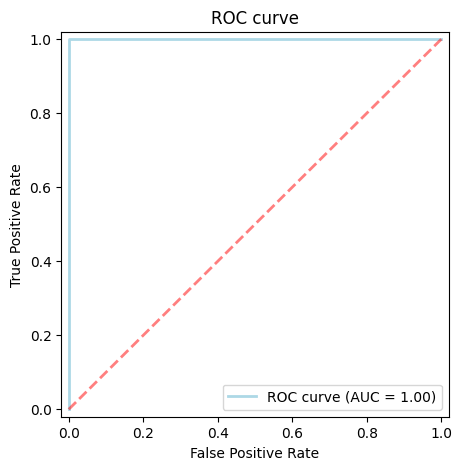

In [ ]:
#plot roc curve

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='lightblue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

# Other Models

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from time import time
from sklearn.metrics import explained_variance_score, mean_absolute_error, r2_score
from matplotlib import pyplot
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier, PassiveAggressiveClassifier, Perceptron
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, BernoulliNB, ComplementNB, MultinomialNB
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

In [ ]:
models = []
models.append(('LR', LogisticRegression(solver='liblinear')))
#models.append(('Ridge', RidgeClassifier()))
models.append(('RF', RandomForestClassifier()))
#models.append(('GB', GradientBoostingClassifier()))
models.append(('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')))

LogisticRegression(solver='liblinear')

LR: 0.928349 (0.003280)
Score for each of the 10 K-fold tests:  [0.92569946 0.92607004 0.93070224 0.92959051 0.92254956 0.92625533
 0.93459329 0.92736706 0.93144339 0.92921994]
LogisticRegression(solver='liblinear')
	Training time: 1.858s
	Prediction time: 16.587s



RandomForestClassifier()

RF: 0.928590 (0.003264)
Score for each of the 10 K-fold tests:  [0.92569946 0.92607004 0.93070224 0.93051695 0.92292014 0.92625533
 0.93459329 0.92792292 0.93144339 0.9297758 ]
RandomForestClassifier()
	Training time: 30.398s
	Prediction time: 294.882s



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

XGBoost: 0.927645 (0.003096)
Score for each of the 10 K-fold tests:  [0.92495831 0.92532889 0.9297758  0.92921994 0.92254956 0.92551417
 0.93403743 0.92699648 0.92959051 0.92847878]
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)
	Training time: 2.388s
	Prediction time: 34.675s



Text(0.5, 0.98, 'Algorithm Comparison')

{'whiskers': [<matplotlib.lines.Line2D at 0x7e5a92c13e20>,
 'caps': [<matplotlib.lines.Line2D at 0x7e5a92c110f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7e5a67ea7e80>,
 'medians': [<matplotlib.lines.Line2D at 0x7e5a92c100a0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7e5a92c127a0>,
 'means': []}

[Text(1, 0, 'LR'), Text(2, 0, 'RF'), Text(3, 0, 'XGBoost')]

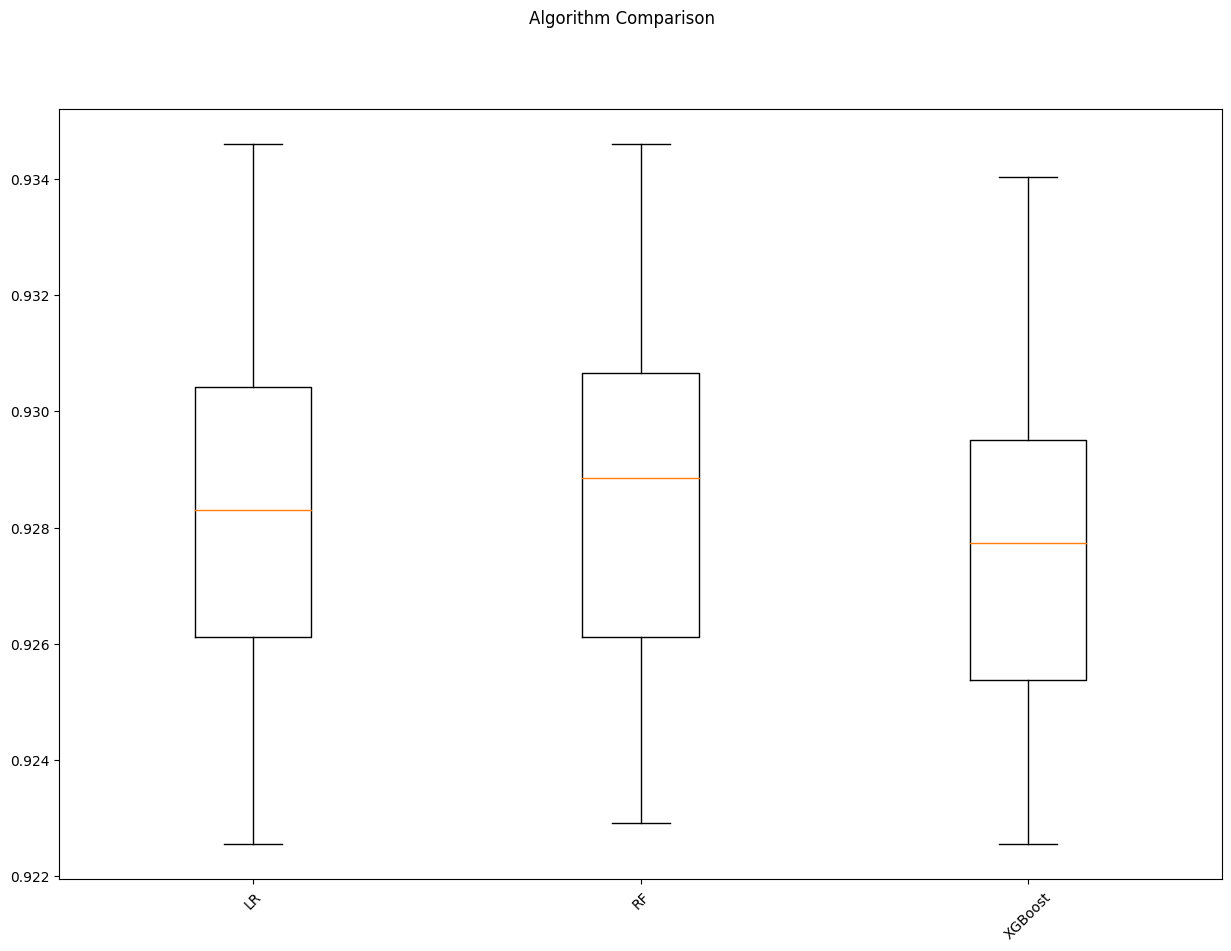

In [ ]:
# Algorithm Harness
# Scoring metrics:
# 'accuracy', 'balanced_accuracy', 'average_precision', 'neg_brier_score', 'f1', 'f1_micro', 'f1_macro', 'f1_weighted',
# 'neg_log_loss', 'precision', 'recall', 'jaccard', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted'
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    start = time()
    kfold = KFold(n_splits=10, random_state=7, shuffle=True)
    model.fit(X_train, y_train)
    train_time = time() - start
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    predict_time = time() - start
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    print("Score for each of the 10 K-fold tests: ",cv_results)
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print()

fig = pyplot.figure(figsize=(15, 10))  # Change the numbers as needed
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names, rotation = 45)  # Added rotation for better visibility
pyplot.show()

# Undersample

In [ ]:
#Undersample
trainData = pd.concat([X_train, y_train], axis=1)
trainData.head(1)

,loan_amount,funded_amount,funded_amount_investor,term,interest_rate,grade,sub_grade,home_ownership,annual_income,loan_title,debit_to_income,delinquency_-_two_years,inquires_-_six_months,open_account,public_record,revolving_utilities,total_accounts,total_received_interest,collection_12_months_medical,last_week_pay,total_collection_amount,log_total_current_balance,log_total_revolving_credit_limit,log_revolving_balance,collection_recovery_fee_ind,total_received_late_fee_ind,recoveries_ind,loan_default_status
33057,0.0,0.0,0.0,0.082606,0.0,0.096379,0.088776,0.088663,0.0,0.094004,0.0,0.09177,0.092567,0.09436,0.100167,0.0,0.086077,0.0,0.092539,0.077529,0.085299,0.0,0.220448,0.193572,0.093841,0.105157,0.094753,0


In [ ]:
# pull out all of the "1-Defaulters" or minority values
idx_defaulters = trainData[trainData.loan_default_status==1].index
print(len(idx_defaulters))

4993


In [ ]:
# Separate the minority class
defaulter_df = trainData.loc[idx_defaulters]
print(defaulter_df.shape)

(4993, 28)


In [ ]:
# now the majority
idx_nondefaulters = trainData[trainData.loan_default_status==0].index
print(len(idx_nondefaulters))

48977


In [ ]:
# Separate the majority class
nondefaulter_df = trainData.loc[idx_nondefaulters]
print(nondefaulter_df.shape)

(48977, 28)


In [ ]:
# Randomly pull out 5006 (idx_defaulters) from the Non Defaulters dataframe
defaulter_df_sample=nondefaulter_df.sample(n=len(idx_defaulters),random_state=123)
defaulter_df_sample.shape

(4993, 28)

In [ ]:
balanced_undersampled_df = pd.concat([defaulter_df, defaulter_df_sample], axis=0)
print(balanced_undersampled_df.loan_default_status.value_counts())
# Shuffling the data set
from sklearn.utils import shuffle
balanced_undersampled_df = shuffle(balanced_undersampled_df)
balanced_undersampled_df.head()

1    4993
0    4993
Name: loan_default_status, dtype: int64


,loan_amount,funded_amount,funded_amount_investor,term,interest_rate,grade,sub_grade,home_ownership,annual_income,loan_title,debit_to_income,delinquency_-_two_years,inquires_-_six_months,open_account,public_record,revolving_utilities,total_accounts,total_received_interest,collection_12_months_medical,last_week_pay,total_collection_amount,log_total_current_balance,log_total_revolving_credit_limit,log_revolving_balance,collection_recovery_fee_ind,total_received_late_fee_ind,recoveries_ind,loan_default_status
25348,0.193572,0.220448,1.0,0.097099,1.0,0.095873,0.091887,0.101550,1.0,0.089720,1.0,0.091770,0.092567,0.093728,0.100167,1.0,0.090422,1.0,0.092539,0.077657,0.107065,1.00000,0.220448,0.235914,0.093841,0.091897,0.092251,1
39253,1.000000,0.256230,1.0,0.097099,1.0,0.091249,0.082523,0.088663,1.0,0.089720,1.0,0.091770,0.092567,0.094360,0.091823,1.0,0.093737,1.0,0.092539,0.107376,0.090661,0.25623,0.220448,0.259613,0.093841,0.091897,0.094753,1
64258,0.256230,0.220448,1.0,0.097099,1.0,0.093896,0.082523,0.088663,1.0,0.094004,1.0,0.093047,0.090172,0.085748,0.091823,1.0,0.095590,1.0,0.091163,0.075118,0.087358,1.00000,0.397533,0.193572,0.093841,0.091897,0.092251,1
6377,0.000000,0.193572,0.0,0.097099,0.0,0.093896,0.094128,0.101550,0.0,0.094004,0.0,0.091770,0.092567,0.093728,0.091823,0.0,0.095225,0.0,0.092539,0.097134,0.089111,0.00000,0.000000,0.000000,0.093841,0.091897,0.092251,0
8567,0.220448,1.000000,1.0,0.097099,1.0,0.096379,0.102050,0.095693,1.0,0.089720,1.0,0.093047,0.092567,0.094360,0.091823,1.0,0.091635,1.0,0.092539,0.098573,0.107869,1.00000,0.288145,0.193572,0.093841,0.091897,0.094753,1


In [ ]:
# Making the new X_train and y_train
X_trainNew = balanced_undersampled_df.iloc[:,0:len(balanced_undersampled_df.columns)-1]
y_trainNew = balanced_undersampled_df.loan_default_status
X_trainNew.head(3)

,loan_amount,funded_amount,funded_amount_investor,term,interest_rate,grade,sub_grade,home_ownership,annual_income,loan_title,debit_to_income,delinquency_-_two_years,inquires_-_six_months,open_account,public_record,revolving_utilities,total_accounts,total_received_interest,collection_12_months_medical,last_week_pay,total_collection_amount,log_total_current_balance,log_total_revolving_credit_limit,log_revolving_balance,collection_recovery_fee_ind,total_received_late_fee_ind,recoveries_ind
25348,0.193572,0.220448,1.0,0.097099,1.0,0.095873,0.091887,0.101550,1.0,0.089720,1.0,0.091770,0.092567,0.093728,0.100167,1.0,0.090422,1.0,0.092539,0.077657,0.107065,1.00000,0.220448,0.235914,0.093841,0.091897,0.092251
39253,1.000000,0.256230,1.0,0.097099,1.0,0.091249,0.082523,0.088663,1.0,0.089720,1.0,0.091770,0.092567,0.094360,0.091823,1.0,0.093737,1.0,0.092539,0.107376,0.090661,0.25623,0.220448,0.259613,0.093841,0.091897,0.094753
64258,0.256230,0.220448,1.0,0.097099,1.0,0.093896,0.082523,0.088663,1.0,0.094004,1.0,0.093047,0.090172,0.085748,0.091823,1.0,0.095590,1.0,0.091163,0.075118,0.087358,1.00000,0.397533,0.193572,0.093841,0.091897,0.092251


In [ ]:
#Recheck Accuracy Score
model_undersampled = LogisticRegression(solver='liblinear', random_state=42)
model_undersampled.fit(X_trainNew, y_trainNew)
# evaluate the model
yhat = model_undersampled.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

LogisticRegression(random_state=42, solver='liblinear')

Accuracy: 100.00


[[12245     0]
 [    0  1248]]


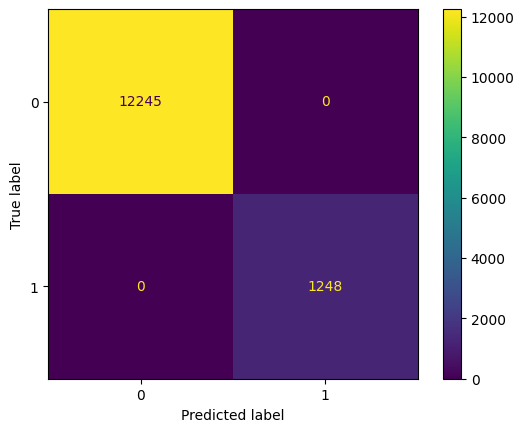

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12245
           1       1.00      1.00      1.00      1248

    accuracy                           1.00     13493
   macro avg       1.00      1.00      1.00     13493
weighted avg       1.00      1.00      1.00     13493



In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test, yhat)
print(cm)
# Plot confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()
print(classification_report(y_test, yhat))

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, yhat)
print(fpr, tpr, thresholds)

[0. 0. 1.] [0. 1. 1.] [inf  1.  0.]


In [ ]:
roc_auc = auc(fpr, tpr)
roc_auc

1.0

<Figure size 500x500 with 0 Axes>

(-0.02, 1.02)

(-0.02, 1.02)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC curve')

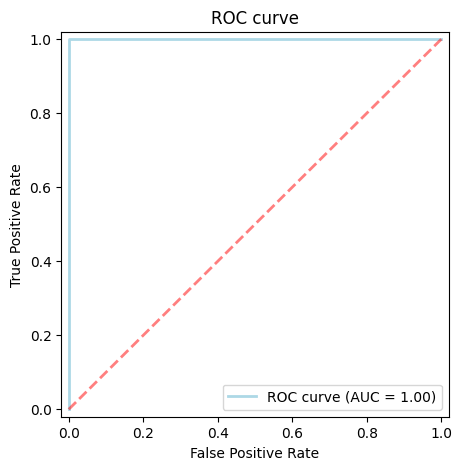

In [ ]:
#plot roc curve

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='lightblue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

# Oversample

In [ ]:
!pip install smote-variants

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.2/416.2 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 7.3 MB/s eta 0:00:00
  Created wheel for minisom: filename=MiniSom-2.3.1-py3-none-any.whl size=10588 sha256=a943990c44fc260fc0f7a4bd01df16bf68d069ffc08a7d7d7b492eea9b1b272a
  Stored in directory: /root/.cache/pip/wheels/c7/92/d2/33bbda5f86fd8830510b16aa98c8dd420129b5cb24248fd6db
  Created wheel for statistics: filename=statistics-1.0.3.5-py3-none-any.whl size=7436 sha256=a0fdeaba720695efd16c4c60add7fdda2a49e82c3d8f8b2e736574acc7434531
  Stored in directory: /root/.cache/pip/wheels/59/bd/aa/41ad56fbb723d36e457b5be74feb992cdac2855a6999ba34a1
Successfully built minisom statistics


In [ ]:
# Shape before oversampling
print("Before OverSampling count of Defaulters: {}".format(sum(y_train==1)))
print("Before OverSampling count of Non-Defaulters: {} \n".format(sum(y_train==0)))

Before OverSampling count of Defaulters: 4993
Before OverSampling count of Non-Defaulters: 48977 



In [ ]:
import smote_variants as sv
# Instantiating the SMOTE class
oversampler= sv.SMOTE()
# Creating new training set
X_train_os, y_train_os = oversampler.sample(np.array(X_train), np.array(y_train))

2023-10-20 15:32:22,073:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': None, 'class_name': 'SMOTE'}")
INFO:smote_variants:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': None, 'class_name': 'SMOTE'}")
2023-10-20 15:32:22,098:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
INFO:smote_variants:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2023-10-20 15:32:22,108:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
INFO:smote_variants:NearestNeighborsWithMetricTensor: kneighbors query minkowski
2023-10-20 15:32:23,296:INFO:SMOTE: simplex sampl

In [ ]:
# Shape after oversampling
print('After OverSampling, the shape of X_train: {}'.format(X_train_os.shape))
print('After OverSampling, the shape of y_train: {} \n'.format(y_train_os.shape))
print("After OverSampling, counts of Defaulters: {}".format(sum(y_train_os==1)))
print("After OverSampling, counts of label Non-Defaulters: {}".format(sum(y_train_os==0)))

After OverSampling, the shape of X_train: (97954, 27)
After OverSampling, the shape of y_train: (97954,) 

After OverSampling, counts of Defaulters: 48977
After OverSampling, counts of label Non-Defaulters: 48977


In [ ]:
#Recheck Accuracy Score
model_oversampled = LogisticRegression(solver='liblinear', random_state=42)
model_oversampled.fit(X_train_os, y_train_os)
# evaluate the model
yhat = model_oversampled.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

LogisticRegression(random_state=42, solver='liblinear')

Accuracy: 100.00


[[12245     0]
 [    0  1248]]


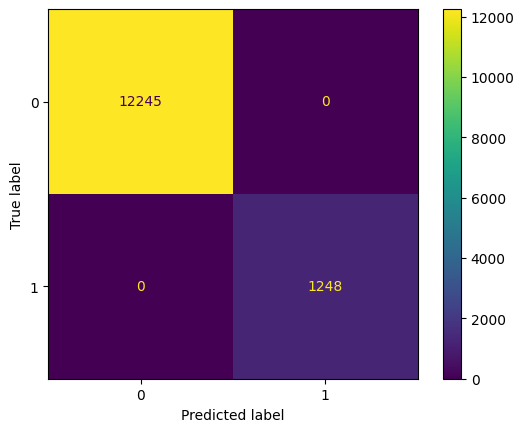

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12245
           1       1.00      1.00      1.00      1248

    accuracy                           1.00     13493
   macro avg       1.00      1.00      1.00     13493
weighted avg       1.00      1.00      1.00     13493



In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test, yhat)
print(cm)
# Plot confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()
print(classification_report(y_test, yhat))

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, yhat)
print(fpr, tpr, thresholds)

[0. 0. 1.] [0. 1. 1.] [inf  1.  0.]


In [ ]:
roc_auc = auc(fpr, tpr)
roc_auc

0.5237017814689968

<Figure size 500x500 with 0 Axes>

(-0.02, 1.02)

(-0.02, 1.02)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC curve')

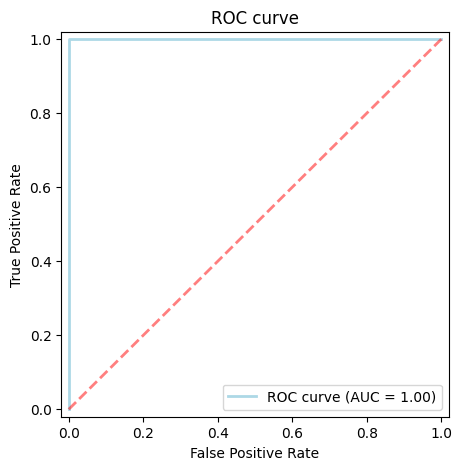

In [ ]:
#plot roc curve

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='lightblue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

2023-10-20 15:32:59,980:INFO:MSMOTE: Running sampling via ('MSMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'n_jobs': 1, 'random_state': None, 'class_name': 'MSMOTE'}")
INFO:smote_variants:MSMOTE: Running sampling via ('MSMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'n_jobs': 1, 'random_state': None, 'class_name': 'MSMOTE'}")
2023-10-20 15:33:00,000:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
INFO:smote_variants:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2023-10-20 15:33:00,015:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
INFO:smote_variants:NearestNeighborsWithMetricTensor: kneighbors query minkowski


After OverSampling, the shape of X_train: (97954, 27)
After OverSampling, the shape of y_train: (97954,) 

After OverSampling, counts of Defaulters: 48977
After OverSampling, counts of label Non-Defaulters: 48977


LogisticRegression(random_state=12, solver='liblinear')

Accuracy: 100.00
[[12245     0]
 [    0  1248]]


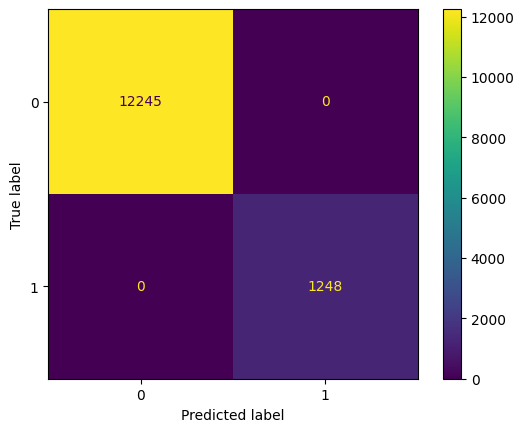

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12245
           1       1.00      1.00      1.00      1248

    accuracy                           1.00     13493
   macro avg       1.00      1.00      1.00     13493
weighted avg       1.00      1.00      1.00     13493



In [ ]:
# Instantiating the MSMOTE class
oversampler= sv.MSMOTE()

# Creating new training set
X_train_os, y_train_os = oversampler.sample(np.array(X_train), np.array(y_train))
# Shape after oversampling
print('After OverSampling, the shape of X_train: {}'.format(X_train_os.shape))
print('After OverSampling, the shape of y_train: {} \n'.format(y_train_os.shape))
print("After OverSampling, counts of Defaulters: {}".format(sum(y_train_os==1)))
print("After OverSampling, counts of label Non-Defaulters: {}".format(sum(y_train_os==0)))

#Recheck Accuracy Score
model_oversampled = LogisticRegression(solver='liblinear', random_state=12)
model_oversampled.fit(X_train_os, y_train_os)
# evaluate the model
yhat = model_oversampled.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

# Compute confusion matrix
cm = confusion_matrix(y_test, yhat)
print(cm)
# Plot confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()
print(classification_report(y_test, yhat))

In [ ]:
roc_auc = auc(fpr, tpr)
roc_auc

1.0

<Figure size 500x500 with 0 Axes>

(-0.02, 1.02)

(-0.02, 1.02)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC curve')

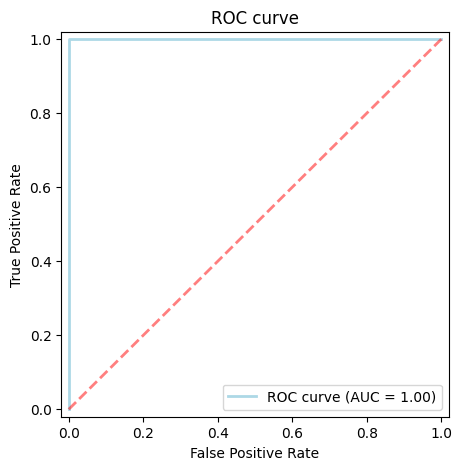

In [ ]:
#plot roc curve

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='lightblue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

# Test Logistic Regression using DictVectorizer Input

In [ ]:

# split into train and test sets
df_X_train_test = df.drop(columns='loan_default_status', axis=1).to_dict(orient='records')

#DictVectorizer can be used in Neural Networks
dv = DictVectorizer(sparse=False)
dv.fit(df_X_train_test)
X = dv.transform(df_X_train_test)

X_train_dv, X_test_dv, y_train_dv, y_test_dv = train_test_split(X, df.loan_default_status, test_size=0.20, random_state=10)
model = LogisticRegression(solver='liblinear', random_state=12)
model.fit(X_train_dv, y_train_dv)
# evaluate the model
y_pred = model.predict(X_test_dv)
# evaluate predictions
accuracy = accuracy_score(y_test_dv, y_pred)
print('Accuracy: %.2f' % (accuracy*100))


In [ ]:
#Test Input
customer={'loan_amount': 458929,
 'funded_amount': 89564,
 'funded_amount_investor': 250000,
 'term': 120,
 'batch_enrolled': 'bat2522922',
 'interest_rate': 8.75,
 'grade': 'Z',
 'sub_grade': 'Z4',
 'home_ownership': 'own',
 'annual_income': 190000,
 'loan_title': 'debt_consolidation',
 'debit_to_income': 12.84758,
 'delinquency_-_two_years': 10,
 'inquires_-_six_months': 10,
 'open_account': 3,
 'public_record': 0,
 'revolving_balance': 0,
 'revolving_utilities': 99.74,
 'total_accounts': 17,
 'total_received_interest': 1500,
 'total_received_late_fee': 5,
 'recoveries': 4,
 'collection_recovery_fee': 0,
 'collection_12_months_medical': 0,
 'last_week_pay': 24,
 'total_collection_amount': 0,
 'total_current_balance': -237847,
 'total_revolving_credit_limit': -3458.0}

X_test_inp = dv.transform([customer])
#model.predict_proba(X_test)[0,1]
# evaluate the model
ypred = model.predict(X_test_inp)
# evaluate predictions
accuracy = accuracy_score(y_test_dv, y_pred)
print('Accuracy: %.2f' % (accuracy*100))

# Neural Network Model

In [ ]:
#using Dict Vectorizer
# split into train and test sets
df_X_train_test = df.drop(columns='loan_default_status', axis=1).to_dict(orient='records')

#DictVectorizer can be used in Neural Networks
dv = DictVectorizer(sparse=False)
dv.fit(df_X_train_test)
dv.feature_names_
X = dv.transform(df_X_train_test)

In [ ]:
df_mr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67463 entries, 0 to 67462
Data columns (total 28 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   loan_amount                       67463 non-null  int64  
 1   funded_amount                     67463 non-null  int64  
 2   funded_amount_investor            67463 non-null  float64
 3   term                              67463 non-null  int64  
 4   interest_rate                     67463 non-null  float64
 5   grade                             67463 non-null  object 
 6   sub_grade                         67463 non-null  object 
 7   home_ownership                    67463 non-null  object 
 8   annual_income                     67463 non-null  float64
 9   loan_title                        67463 non-null  object 
 10  debit_to_income                   67463 non-null  float64
 11  delinquency_-_two_years           67463 non-null  int64  
 12  inqu

In [ ]:
features.head(1)

,loan_amount,funded_amount,funded_amount_investor,term,interest_rate,grade,sub_grade,home_ownership,annual_income,loan_title,debit_to_income,delinquency_-_two_years,inquires_-_six_months,open_account,public_record,revolving_utilities,total_accounts,total_received_interest,collection_12_months_medical,last_week_pay,total_collection_amount,log_total_current_balance,log_total_revolving_credit_limit,log_revolving_balance,collection_recovery_fee_ind,total_received_late_fee_ind,recoveries_ind
0,10000,32236,12329.36286,59,11.135007,b,c4,mortgage,176346.6267,debt_consolidation,16.284758,1,0,13,0,74.932551,7,2929.646315,0,49,31,12.648519,8.797851,10.096048,0,0,0


In [ ]:
# load the model from disk
from tensorflow.keras.models import load_model
model = load_model('/content/model')
scaler = joblib.load('/content/scaler.pkl')
encoder = joblib.load('/content/encoder.pkl')

data={'loan_amount': 1000, 'funded_amount': 0, 'funded_amount_investor': 0, 'term': 36, 'interest_rate': 0.0, 'grade': 'a', 'sub_grade': 'a1', 'home_ownership': 'mortgage', 'annual_income': 0.0, 'loan_title': 'credit_card_refinance_loan', 'debit_to_income': 0.0, 'delinquency_two_years': 0, 'inquires_six_months': 0, 'open_account': 1, 'public_record': 0, 'revolving_utilities': 0.0, 'total_accounts': 1, 'total_received_interest': 0.0, 'collection_12_months_medical': 0, 'last_week_pay': 1, 'total_collection_amount': 0, 'total_current_balance': 0, 'total_revolving_credit_limit': 0, 'revolving_balance': 0, 'collection_recovery_fee': 11.0, 'total_received_late_fee': 11.0, 'recoveries': 11.0 }
data={'loan_amount': 1000, 'funded_amount': 0, 'funded_amount_investor': 0, 'term': 36, 'interest_rate': 0.0, 'grade': 'a', 'sub_grade': 'a1', 'home_ownership': 'mortgage', 'annual_income': 0.0, 'loan_title': 'credit_card_refinance_loan', 'debit_to_income': 0.0, 'delinquency_two_years': 0, 'inquires_six_months': 0, 'open_account': 1, 'public_record': 0, 'revolving_balance': 0, 'revolving_utilities': 0.0, 'total_accounts': 1, 'total_received_interest': 0.0, 'total_received_late_fee': 0.0, 'recoveries': 0.0, 'collection_recovery_fee': 0.0, 'collection_12_months_medical': 0, 'last_week_pay': 1, 'total_collection_amount': 0, 'total_current_balance': 0, 'total_revolving_credit_limit': 0}
df1 = pd.DataFrame.from_dict(pd.json_normalize(data), orient='columns')
df1.rename(columns={"delinquency_two_years": "delinquency_-_two_years",
                    "inquires_six_months": "inquires_-_six_months",
                    "revolving_balance": "log_revolving_balance",
                    "total_current_balance": "log_total_current_balance",
                    "total_revolving_credit_limit": "log_total_revolving_credit_limit",
                    "collection_recovery_fee": "collection_recovery_fee_ind",
                    "total_received_late_fee": "total_received_late_fee_ind",
                    "recoveries": "recoveries_ind"}, inplace=True)
df1.head()
df1.log_revolving_balance=np.log(1+df1.log_revolving_balance)
df1.log_total_current_balance=np.log(1+df1.log_total_current_balance)
df1.log_total_revolving_credit_limit=np.log(1+df1.log_total_revolving_credit_limit)


encode = encoder.transform(df1)
scaler = scaler.transform(encode)
prediction = model.predict(scaler)
test_loss, test_accuracy = model.evaluate(scaler, y_test)
print(-np.log10(prediction))

,loan_amount,funded_amount,funded_amount_investor,term,interest_rate,grade,sub_grade,home_ownership,annual_income,loan_title,debit_to_income,delinquency_-_two_years,inquires_-_six_months,open_account,public_record,revolving_utilities,total_accounts,total_received_interest,collection_12_months_medical,last_week_pay,total_collection_amount,log_total_current_balance,log_total_revolving_credit_limit,log_revolving_balance,collection_recovery_fee_ind,total_received_late_fee_ind,recoveries_ind
0,1000,0,0,36,0.0,a,a1,mortgage,0.0,credit_card_refinance_loan,0.0,0,0,1,0,0.0,1,0.0,0,1,0,0,0,0,11.0,11.0,11.0


1/1 [==============================] - 0s 123ms/step
[[7.27]]
